<a href="https://www.kaggle.com/code/jhtkoo0426/house-price-predictions-ft-catboostregressor?scriptVersionId=150681667" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In [1]:
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Models
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor

# Load datasets

In [2]:
train_ds = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_ds  = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
X = train_ds.drop(columns=['Id', 'SalePrice'], axis=1)
y = train_ds['SalePrice']

# Exploring the dataset

## Dataset information
First, let's see what data types the dataset consists of.

In [4]:
# X.info()

From the dataset information, we observe that there are:
- 36 columns containing **numerical** data; and
- 43 columns containing **categorical or object** data

Since the handling of these two types of data differs, we will segregate them accordingly.

In [5]:
numeric_features = X.select_dtypes(include=['number'])
categorical_features = X.select_dtypes(include=['object'])
categorical_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

<Axes: >

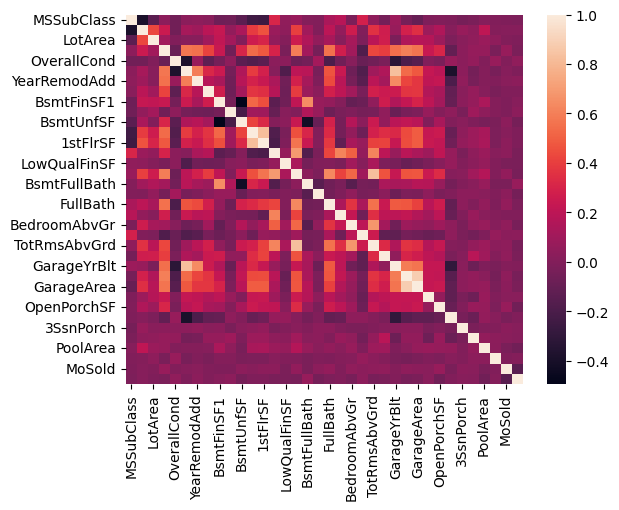

In [6]:
sns.heatmap(numeric_features.corr())

## Null columns
Let's take a look at which columns contain `NULL` values. This will provide us a reference point when we construct a pipeline class to process `NULL` values.

In [7]:
feature_contains_null = X.isna().sum().sort_values(ascending=False)
feature_contains_null[feature_contains_null > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

# Data preprocessing
Deal with `NULL` values according to the data description and treating special cases.

In [8]:
class NullProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Fill categorical NA values based on data description
        for col in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'MiscFeature']:
            X[col] = X[col].fillna('NA')
        
        for col in ['MasVnrType']:
            X[col] = X[col].fillna('None')
        
        for col in ['MasVnrArea', 'LotFrontage']:
            X[col] = X[col].fillna(0)
            
        # Special cases - we want to fill NULL values in these columns with special values instead.
        X['Electrical'] = X['Electrical'].fillna('SBrkr')
        return X

# Create pipeline

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('column_dropper', 'drop', ['PoolQC', 'GarageYrBlt']),
    ('num', numeric_transformer, numeric_features.columns),
    ('cat', categorical_transformer, categorical_features.columns),
])

Combine preprocessing with the model in a single pipeline

In [10]:
pipeline = Pipeline(steps=[
    ('null_processor', NullProcessor()),
    ('preprocessor', preprocessor),
    ('classifier', CatBoostRegressor()),
])

Fit the pipeline on the training data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
pipeline.fit(X_train, y_train)

Learning rate set to 0.04196
0:	learn: 75957.9076840	total: 57.5ms	remaining: 57.5s
1:	learn: 73833.6070304	total: 60.8ms	remaining: 30.3s
2:	learn: 71830.7689004	total: 63.8ms	remaining: 21.2s
3:	learn: 70008.2862923	total: 67.2ms	remaining: 16.7s
4:	learn: 68271.9902645	total: 70.5ms	remaining: 14s
5:	learn: 66489.4399271	total: 73.6ms	remaining: 12.2s
6:	learn: 64765.7734540	total: 76.6ms	remaining: 10.9s
7:	learn: 63184.9455134	total: 79.6ms	remaining: 9.88s
8:	learn: 61578.7635852	total: 82.6ms	remaining: 9.09s
9:	learn: 60280.4470099	total: 85.6ms	remaining: 8.47s
10:	learn: 58908.5026866	total: 89.1ms	remaining: 8.01s
11:	learn: 57566.0614610	total: 92.2ms	remaining: 7.59s
12:	learn: 56384.1226357	total: 95.3ms	remaining: 7.24s
13:	learn: 55092.3723717	total: 99.4ms	remaining: 7s
14:	learn: 53821.2405775	total: 103ms	remaining: 6.75s
15:	learn: 52798.7798320	total: 106ms	remaining: 6.54s
16:	learn: 51787.7850848	total: 110ms	remaining: 6.35s
17:	learn: 50738.0411842	total: 114ms

Pipeline(steps=[('null_processor', NullProcessor()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('column_dropper', 'drop',
                                                  ['PoolQC', 'GarageYrBlt']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFi...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('classifier',
                 <catboost.core.CatBoostRegressor object at 0x7a7c86b1fd60>)])

In [13]:
train_predictions = pipeline.predict(X_test)

In [14]:
rmse_score = np.sqrt(mean_squared_error(train_predictions, y_test))
rmse_score

32973.72954418106

# Making predictions & submission file

Make predictions on the testing data

In [15]:
submission_df = test_ds[['Id']]
test_ds = test_ds.drop(columns=['Id'])

In [16]:
predicted_prices = pipeline.predict(test_ds)

In [17]:
submission_df['SalePrice'] = predicted_prices
submission_df = submission_df.set_index('Id')
submission = submission_df.to_csv("submission.csv", encoding='utf-8')

In [18]:
!head submission.csv

Id,SalePrice
1461,127317.50049941152
1462,170952.37167544104
1463,187289.89959839432
1464,191530.22947088865
1465,188534.19601980003
1466,173848.7357084534
1467,171878.32634857393
1468,167107.3017543519
1469,189354.66491960952
